## Code


In [43]:
!pip install CFEDemands
import cfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Choose dataset ##
USE = "ICRISAT"
#USE = "Tanzania"

# Results can be made persistent by saving them, and then re-loading...
if USE=="ICRISAT":
    DIR = "./IndianICRISAT/"
    r = cfe.from_dataset(DIR+'indian_icrisat.ds')
    USE_GOOD = 'Milk' #'Bengalgram dhal'
elif USE=="Tanzania":
    DIR = "./TanzanianNPS/"
    r = cfe.from_dataset(DIR+'tanzanian_nps.ds')
    USE_GOOD = 'Ripe Bananas'
else:
    raise ValueError("No such value of USE")

fct = pd.read_pickle(DIR+'fct.df')
rda = pd.read_pickle(DIR+"rda.df")

# Use prices, distribution of budgets from first round, first market:

t = 84
m = 'A'

# Distribution of predicted total expenditures
xhat = r.get_predicted_expenditures().sum('i')
xhat = xhat.where(xhat>0,np.nan)

# Note selection of prices for first period and first market
p = r.prices.sel(t=t,m=m).fillna(1).copy()

##change one price of item
def my_prices(p0,p=p,i=USE_GOOD):
    p = p.copy()
    p.loc[i] = p0
    return p

# Now fix up FCT

# Change some labels in fct
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['Item name'].str.title()

# Replace missing with zeros
fct = fct.fillna(0)

#try:
#    fct.index = fct.index.droplevel('unit')
#except AttributeError: pass # No units?

def nutrient_demand(x,p,z=None):
    c = r.demands(x,p,z=z)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda


def compensating_variation(U0,p0,p1):
    x0 = cfe.demands.hicksian.expenditurefunction(U0,p0,np.exp(r.alpha),r.beta,0)
    x1 =  cfe.demands.hicksian.expenditurefunction(U0,p1,np.exp(r.alpha),r.beta,0)

    return x1-x0

def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    return dp.T@r.demands(U0,p1,type=type)


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return revenue(U0,p0,p1,type='Hicksian') - cv
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return compensated_nutrient_demand(U,p)/hh_rda

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [18]:
##chang household characteristic structure below
#M 0-3	F 0-3	M 4-8	F 4-8	M 9-13	F 9-13	M 14-18	F 14-18 W19-30	F 19-30	M 31-50	F 31-50	M 51+	F 51+

zbar = r.z.sel(t=r.firstround).mean(['j','m'])[:-1] # Leave out log HSize
## use our characteristic 
my_z = np.array([0,0,0,3,3,0,0,0,0,1,1,0,0])
hh_rda = rda.replace('',0).T@zbar

In [19]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
x0 = xhat.sel(t=t,m=m).quantile(0.5,'j') # Budget (median household)
nutrient_demand(x0,p)

Protein            6332.921959
Fat               10810.224605
fibre               238.128346
carbohydrate      22217.265545
Calories         190472.877709
energy_kj        797471.852241
Calcium          237479.794113
Iron               1031.844487
Betacarotene      27360.150308
caroten_total    397275.078342
Thiamine             63.953649
Riboflavin          204.683128
Niacin              179.689124
Ascorbic Acid      5724.590841
ext_source            0.000000
pu_cal           247977.641610
pu_prot            7443.918926
pu_fat            13107.231471
dtype: float64

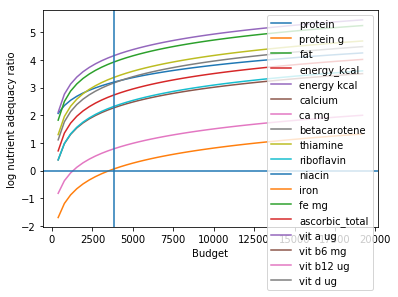

In [20]:
## with all nutrition
X = np.linspace(x0/10,x0*5,50)
x0 = xhat.sel(t=t,m=m).quantile(0.5,'j')

plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p)) for x in X},axis=1).T)
plt.legend(d)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

## choose five main nutritient components

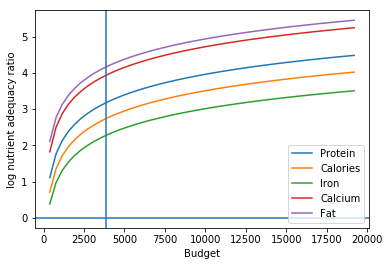

In [21]:
UseNutrients = ['Protein','Calories','Iron','Calcium','Fat']

x0 = xhat.sel(t=t,m=m).quantile(0.5,'j')
X = np.linspace(x0/10,x0*5,50)


plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)


In [17]:
x0 = xhat.sel(t=84,m='A').quantile(0.5,'j')
x0

<xarray.DataArray ()>
array(3840.890844)
Coordinates:
    quantile  float64 0.5

### Household in middle class with budget as 3840.89. As we can see, they consume more than recommaned nutrition level. In this case, we target low income households, whom the policies will affect more.

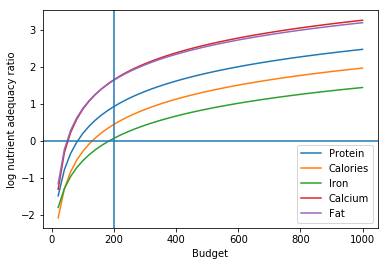

In [24]:
my_z = np.array([0,0,0,1,1,0,0,0,0,1,1,0,0])
hh_rda = rda.replace('',0).T@my_z


UseNutrients = ['Protein','Calories','Iron','Calcium','Fat']
x0 = 200
X = np.linspace(x0/10,x0*5,50)


plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)



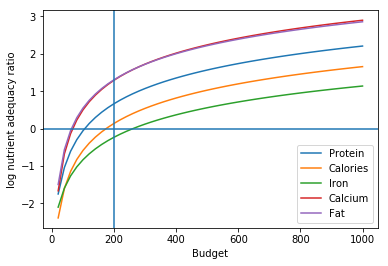

In [25]:
my_z = np.array([0,0,0,2,2,0,0,0,0,1,1,0,0])
hh_rda = rda.replace('',0).T@my_z


UseNutrients = ['Protein','Calories','Iron','Calcium','Fat']
x0 = 200
X = np.linspace(x0/10,x0*5,50)


plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)



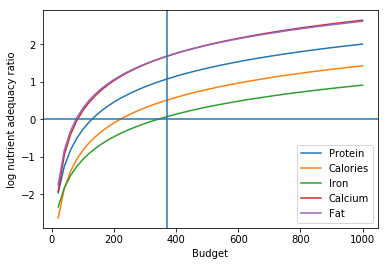

In [33]:
my_z = np.array([0,0,0,3,3,0,0,0,0,1,1,0,0])
hh_rda = rda.replace('',0).T@my_z


UseNutrients = ['Protein','Calories','Iron','Calcium','Fat']
x0 = 200
X = np.linspace(x0/10,x0*5,50)


plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)



## On the other hand, household with more kids need more budget to meet nutrition level. In this project, the special population is low income household with 3 girls and 3 boys

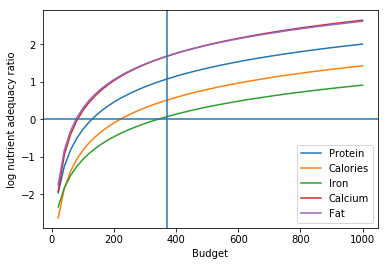

In [34]:
my_z = np.array([0,0,0,3,3,0,0,0,0,1,1,0,0])
hh_rda = rda.replace('',0).T@my_z


UseNutrients = ['Protein','Calories','Iron','Calcium','Fat']
x0 = 200
X = np.linspace(x0/10,x0*5,50)


plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(370)



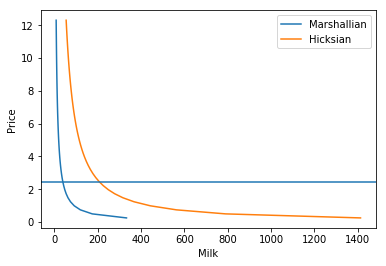

In [35]:
## for target population, if household income above 370, they are estimated to reach the nutrition level.

x0 = 370
USE_GOOD = 'Milk'
U0 = cfe.demands.marshallian.indirect_utility(x0,p,np.exp(r.alpha),r.beta,0)

plt.plot([r.demands(poorer_x,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.plot([r.demands(poorer_x,my_prices(p0,i=USE_GOOD),type="Hicksian")[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
plt.axhline(p.sel(i=USE_GOOD).values)
plt.legend(("Marshallian","Hicksian"))

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

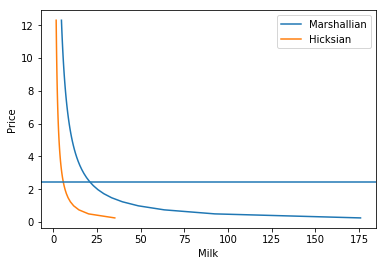

In [40]:
x0 = 370
USE_GOOD = 'Milk'
p = r.prices.sel(t=84,m='A').copy()
U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=USE_GOOD),type="Hicksian")[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
plt.axhline(p.sel(i=USE_GOOD).values)
plt.legend(("Marshallian","Hicksian"))
plt

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

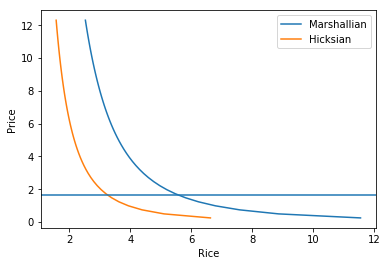

In [41]:
x0 = 370
USE_GOOD = 'Rice'
#USE_GOOD = 'Sugar'
p = r.prices.sel(t=84,m='A').copy()
U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=USE_GOOD),type="Hicksian")[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
plt.axhline(p.sel(i=USE_GOOD).values)
plt.legend(("Marshallian","Hicksian"))
plt

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

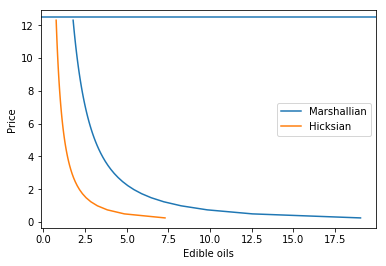

In [42]:
x0 = 370
USE_GOOD = 'Edible oils'
#USE_GOOD = 'Sugar'
p = r.prices.sel(t=84,m='A').copy()
U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=USE_GOOD),type="Hicksian")[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
plt.axhline(p.sel(i=USE_GOOD).values)
plt.legend(("Marshallian","Hicksian"))
plt

Text(0.5,0,'Price of Milk')

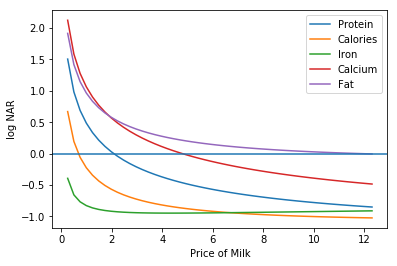

In [44]:
USE_GOOD = 'Milk'

fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % USE_GOOD)

Text(0.5,0,'Price of Rice')

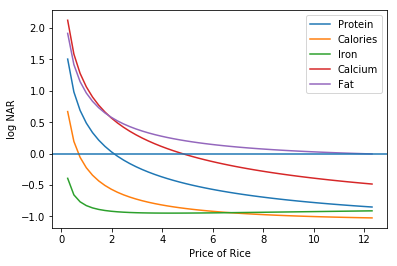

In [46]:
USE_GOOD = 'Rice'
fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % USE_GOOD)